# Spatiotemporal data

### 03_02 Data acquisition

In this section, we are going to study the temporal dimension of spatial data. For this, we will rely on a series of population rasters - snapshots of population levels published by the European Commission's [Global Human Settlement layer](https://human-settlement.emergency.copernicus.eu/download.php?ds=pop).

In this data set, they publish worldwide population grid data in 5-year-long epochs.

You may go and download the data files for each epoch manually, or follow the instructions below and download them with a short Python script.

First, we import the necessary libraries to download the data, and then write the following short function, which downloads the data files for each epoch, and then unzips them into their own data folders.

Then, we will loop through the temporal epochs from 2000 to 2025.

**Note - please note that each file is around 500MB, so make sure you have enough space on your working disk. Otherwise feel free to decrease the temporal span of the downloader and run the code for a shorter period.**

In [11]:
import os, sys, pathlib, requests, shutil, zipfile
from pathlib import Path

import geopandas as gpd
import rasterio
from rasterio.mask import mask



def download(url, out_dir):
    out_dir = Path(out_dir).expanduser()           # 1️⃣ make it a Path
    out_dir.mkdir(parents=True, exist_ok=True)

    path = out_dir / url.split("/")[-1]            # 2️⃣ keep this a Path
    if not path.exists():
        print(f"Downloading {url}\n→ {path}")
    
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(path, "wb") as f:
                shutil.copyfileobj(r.raw, f)
    
        extract_dir = out_dir / path.stem              # 3️⃣ .stem now works
        print(f"Extracting to {extract_dir}")
        with zipfile.ZipFile(path) as z:
            z.extractall(extract_dir)
    
        path.unlink()                                  # delete the .zip
    print("Done.")



In [12]:
folder_raw = 'GHSL_raw'
os.makedirs(folder_raw, exist_ok = True)

In [1]:
for epoch in range(2000, 2030, 5):

    url = (
    "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/"
    "GHS_POP_GLOBE_R2023A/"
    "GHS_POP_E" + str(epoch) + "_GLOBE_R2023A_4326_30ss/V1-0/"
    "GHS_POP_E" + str(epoch) + "_GLOBE_R2023A_4326_30ss_V1_0.zip")

    download(url, folder_raw)


'\nfor epoch in range(2000, 2030, 5):\n\n    url = (\n    "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/"\n    "GHS_POP_GLOBE_R2023A/"\n    "GHS_POP_E" + str(epoch) + "_GLOBE_R2023A_4326_30ss/V1-0/"\n    "GHS_POP_E" + str(epoch) + "_GLOBE_R2023A_4326_30ss_V1_0.zip")\n\n    download(url, folder_raw)\n'

### 03_03 Data preprocessing

So have have downloaded about ten different raster grids, for now, covering the entire world.

To keep our data volume managable, now we will preprocess the downloaded raw, global population grids and restrict them to the area of Germany.

For this, first let's get the polygon boundaries of Germany from the NUTS area data set we have been using before. We can easily extract that by using the unary_union command of shapely. Once extracted, let's do a quick visual on Germany.



<Axes: >

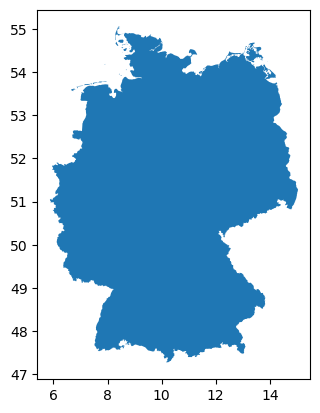

In [14]:
import geopandas as gpd
from shapely.ops import unary_union
import matplotlib.pyplot as plt

gdf_nuts1 = gpd.read_file("NUTS 1 - 2016")  # folder / shapefile, GeoPackage, etc.
gdf_nuts1 = gdf_nuts1[gdf_nuts1.CNTR_CODE=='DE']

# 2 dissolve everything into one multipart polygon
germany_geom = unary_union(gdf_nuts1.geometry)       # shapely geometry

# 3 wrap it in a GeoDataFrame so you can plot / save
gdf_germany = gpd.GeoDataFrame(
    {"name": ["Germany"]},           # add any attrs you like
    geometry=[germany_geom],
    crs=gdf_nuts1.crs,
)

gdf_germany.plot()

Now we query all the raster files, and then iterate throught them all, use the polygon boundaries of Germany to crop them using rasterio's mask, and export the new cropped rasters


In [18]:
# preparations
rasters = [Path(folder_raw + '/' + f + '/' + f  + '.tif') for f in os.listdir(folder_raw) if 'GHS' in f] 
folder_proc = Path('GHSL_preproc')
os.makedirs(folder_proc, exist_ok = True)

In [50]:
for src_path in rasters:
    
    print(f"\nProcessing {src_path.name}")

    # —— open original raster ——————————————————————————
    with rasterio.open(src_path) as src:
        h0, w0 = src.height, src.width
        print(f"   original size : {w0} × {h0} px")

        # reproject Germany polygon to raster CRS
        germany_geom = gdf_germany.to_crs(src.crs).geometry

        # clip & mask
        data, transform = mask( src, 
                               germany_geom, 
                               crop=True, 
                               nodata=src.nodata)

        profile = src.profile
        profile.update( height=data.shape[1],  width=data.shape[2], transform=transform )

    # —— save cropped raster ——————————————————————————
    out_tif = folder_proc / f"{src_path.stem}_Germany.tif"
    with rasterio.open(out_tif, "w", **profile) as dst:
        dst.write(data)

    h1, w1 = data.shape[1], data.shape[2]
    print(f"   cropped size   : {w1} × {h1} px")
    print(f"   saved to       : {out_tif}")



Processing GHS_POP_E2010_GLOBE_R2023A_4326_30ss_V1_0.tif
   original size : 43202 × 21384 px
   cropped size   : 1101 × 936 px
   saved to       : GHSL_preproc/GHS_POP_E2010_GLOBE_R2023A_4326_30ss_V1_0_Germany.tif

Processing GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif
   original size : 43202 × 21384 px
   cropped size   : 1101 × 936 px
   saved to       : GHSL_preproc/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0_Germany.tif

Processing GHS_POP_E2025_GLOBE_R2023A_4326_30ss_V1_0.tif
   original size : 43202 × 21384 px
   cropped size   : 1101 × 936 px
   saved to       : GHSL_preproc/GHS_POP_E2025_GLOBE_R2023A_4326_30ss_V1_0_Germany.tif

Processing GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0.tif
   original size : 43202 × 21384 px
   cropped size   : 1101 × 936 px
   saved to       : GHSL_preproc/GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0_Germany.tif

Processing GHS_POP_E2000_GLOBE_R2023A_4326_30ss_V1_0.tif
   original size : 43202 × 21384 px
   cropped size   : 1101 × 936 px
   saved to 

As the output pixel sizes show, we managed to decrease the global raster grid into the size of roughly 1000 pixels in each directions, now covering Germany only.

### 03_04 Visualize the temporal changes in spatial data

Let's visualize the different raster snapshots! 

For this, we will use log scaling, so we need to import the related function from matplotlib.

Then, we define the location of the image files, and with a simple one-liner, load their single-channel raster data into a list of rasters stored as numpy arrays.

In [33]:
from matplotlib.colors import LogNorm
import numpy as np

# grab 6 files from the output folder
raster_files  = sorted(Path("GHSL_preproc").glob("*_Germany.tif"))[:6]
raster_data = [rasterio.open(p).read(1, masked=True) for p in raster_files]
raster_files

[PosixPath('GHSL_preproc/GHS_POP_E2000_GLOBE_R2023A_4326_30ss_V1_0_Germany.tif'),
 PosixPath('GHSL_preproc/GHS_POP_E2005_GLOBE_R2023A_4326_30ss_V1_0_Germany.tif'),
 PosixPath('GHSL_preproc/GHS_POP_E2010_GLOBE_R2023A_4326_30ss_V1_0_Germany.tif'),
 PosixPath('GHSL_preproc/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0_Germany.tif'),
 PosixPath('GHSL_preproc/GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0_Germany.tif'),
 PosixPath('GHSL_preproc/GHS_POP_E2025_GLOBE_R2023A_4326_30ss_V1_0_Germany.tif')]

Then we restrict the data to the 2-98 percentile intervals of the original, non-zero values. This way we cut all outliers from the visuals, ensuring a balanced coloring. This step is also known as colour stretching.

In [34]:
# common colour stretch (2–98 % of all positive values)
vmin, vmax = np.percentile(np.concatenate([a[a > 0] for a in raster_data]), (2, 98))
norm = LogNorm(vmin, vmax)

/Users/milan/anaconda3/envs/GEO/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Then, let's drop the matplotlib figure

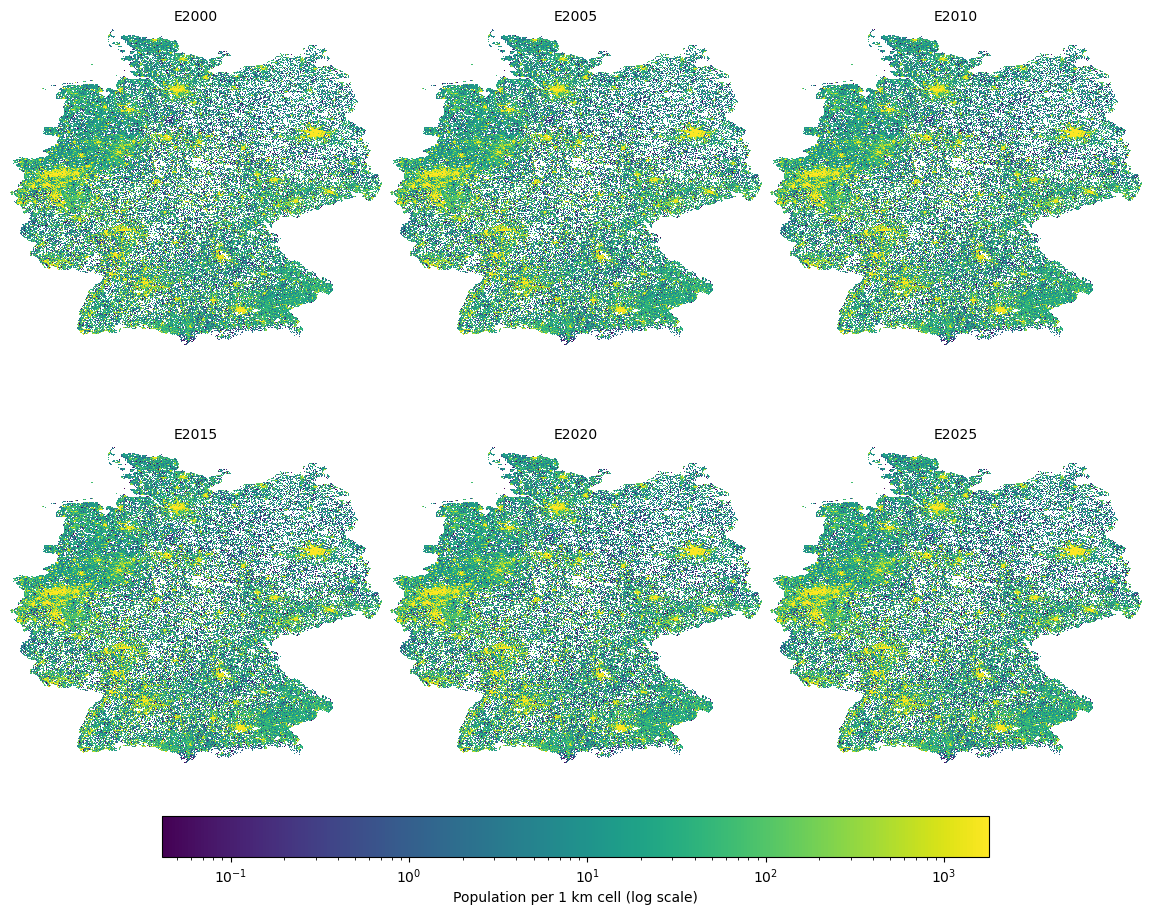

In [35]:

# ---- plot -----------------------------------------------------------------
nrows, ncols = 2, 3
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(3.8 * ncols, 4.9 * nrows),
    constrained_layout=True,
)

# Flatten axis grid for easy zip
axes_flat = axes.ravel()

for ax, tif in zip(axes_flat, raster_files):
    epoch = tif.stem.split("_")[2]             # 'E2015', 'E2020', …
    with rasterio.open(tif) as src:
        data = src.read(1, masked=True)
        im = ax.imshow(
            np.where(data.mask | (data <= 0), np.nan, data),
            cmap="viridis",
            norm=LogNorm(vmin=vmin, vmax=vmax),
            interpolation="none",
        )
    ax.set_title(epoch, fontsize=10)
    ax.axis("off")



# shared colour-bar
cbar = fig.colorbar(
    im, ax=axes_flat, orientation="horizontal", fraction=0.05, pad=0.06
)
cbar.set_label("Population per 1 km cell (log scale)")



So now we have a series of temporal snapshots of spatial data. However, from these images, it is quite hard to see what has happened - how did the population level change?

Let's see how we can determine that!

### 03_05 Change detection on raster data

Let's pick two example epochs, for instance, 2005 and 2025. This way, we will go after the pixel-level population change throughout 20 years.

First, we define the location of the two cropped raster files, and then read them. 



In [53]:
epoch1, epoch2 = 2005, 2025

p1 = next(Path("GHSL_preproc").glob(f"*E{epoch1}*_Germany.tif"))
p2 = next(Path("GHSL_preproc").glob(f"*E{epoch2}*_Germany.tif"))

After reading the two raster grids, wee simply create a new grid by taking their difference and cloning its metadata!

In [54]:
with rasterio.open(p1) as r1, rasterio.open(p2) as r2:
    a1 = r1.read(1, masked=True)
    a2 = r2.read(1, masked=True)
    diff = a2 - a1                     # absolute change  (people / pixel)

    profile = r1.profile               # clone metadata from the first file
    profile.update(dtype="float32", nodata=np.nan)


Then, for the sake of easier interpretability, let's normalize the absolute change levels to relative percentage scores, and use a red-blue colormap.

In this coloring, red means population gain in a given pixel, while blue denotes population loss.

/Users/milan/anaconda3/envs/GEO/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


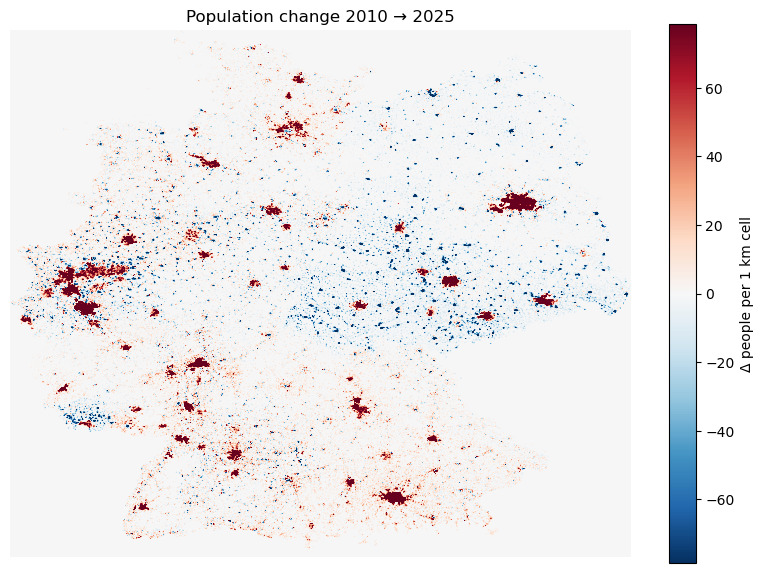

In [55]:
from matplotlib.colors import TwoSlopeNorm


# quick visual with a diverging palette (blue = loss, red = gain)
v = np.nanpercentile(np.abs(diff), 98)      # symmetric stretch around zero
norm = TwoSlopeNorm(vmin=-v, vcenter=0, vmax=v)

plt.figure(figsize=(10, 7))
plt.imshow(np.where(diff.mask, np.nan, diff), cmap="RdBu_r", norm=norm)
plt.title(f"Population change {epoch1} → {epoch2}")
plt.axis("off")
cbar = plt.colorbar(label="Δ people per 1 km cell")
plt.show()


Such a map can tell very detailed stories about a country, from urbanisation to economic growth, changes in agricultural work and many others.


However, in the case of Germany we see a very clear West-East divide, which most likely correspond to the former East Germany - West Germany division after the second world war.

### 03_06 An advanced file format - NetCDF

While change detection worked well, the previous series of six images hints that images might not be the best way to handle spatiotemporal raster data.

While a series of images will make a lot of sense as an animation, that will be part of another course.

Here, instead, we focus on a more advanced raster file format called NetCDF which you may encounter during your geospatial journey

For this, we will get to know three new libraries - xarray, rioxarray, and h5netcdf

While xarray provides Pandas-style, labeled N-dimensional arrays for scientific data, such as a time series of raster grids, rioxarray plugs rasterio/GDAL into xarray so those arrays become fully georeferenced. Besids, h5netcdf is reponsible to handle netcdf files.

In [39]:
import xarray as xr
import rioxarray as rxr
import h5netcdf

Now first load every raster as an xarray DataArray, and attach a time coordinate to it - this time, our epochs.

Let's call the list containing ther asters a cube list, since we are stacing muktiple 2-D rasters (x × y) along a third time axis, hence arrive at a 3-D “data cube.”



In [40]:
# Load every raster as a DataArray with a time coordinate
cube_list = []
for tif in sorted(Path("GHSL_preproc").glob("*_Germany.tif")):
    year = int(tif.stem.split("_")[2][1:])        # 'E2005' -> 2005
    da   = rxr.open_rasterio(tif).squeeze()       # drop band dim  -> (y,x)
    da   = da.assign_coords(time=year).expand_dims("time")  # -> (time,y,x)
    cube_list.append(da)

Then concatenate them along the time dimension to create a single image, ready to be exported as netcdf file:

In [41]:
# Concatenate along the new time dimension
cube = xr.concat(cube_list, dim="time")           # (time,y,x)
cube.name = "population"                          # variable name
cube.attrs.update(long_name="GHSL population", units="people per 1 km cell")

Now let's export the file. 

While exporting a NetCDF-4, we need to specifiy a few things in the encoding dictionary, as well as define the spatial referencing.  

- zlib: True → apply a standard compression method
- complevel: 4 → compression strength: 0 = none, 9 = max; level 4 is a good speed/size trade-off.
- chunksizes: (1, 512, 512) → write the data in internal blocks of 1 time-step × 512 rows × 512 cols so you can later read just one epoch or a 512×512 window without decompressing the whole cube.

In [42]:
# define output file an
out_nc = Path("GHSL_Germany_2000-2025.nc")
out_nc.unlink(missing_ok=True)

#  tag spatial info (as before)
cube.rio.set_spatial_dims("x", "y", inplace=True)
cube.rio.write_crs("EPSG:4326", inplace=True)
cube.attrs["grid_mapping"] = "spatial_ref"          # ← link the CRS variable

# write NetCDF (let xarray pick the backend)
cube.to_netcdf(out_nc, encoding={
    "population": {"zlib": True,
                   "complevel": 4,
                   "chunksizes": (1, 512, 512)}
})


### 03_07 Read and visualise NetCDF data

First, we open the data cube:

In [43]:
ds = xr.open_dataset(out_nc, decode_coords="all")

print(ds)                                           # shows dims, coords, attrs

<xarray.Dataset> Size: 445MB
Dimensions:      (x: 3303, y: 2808, time: 6)
Coordinates:
  * x            (x) float64 26kB 5.871 5.871 5.871 5.88 ... 15.04 15.04 15.04
  * y            (y) float64 22kB 47.27 47.27 47.27 47.28 ... 55.06 55.06 55.06
  * time         (time) int64 48B 2000 2005 2010 2015 2020 2025
    band         int64 8B ...
    spatial_ref  int64 8B ...
Data variables:
    population   (time, y, x) float64 445MB ...


This output shows the pixel size, the number of temporal points, and also an example of the x, y, and time coordinates. In the latter, you can observe the epochs we defined earlier.

Additionally, we can see here that the data stored is called population, and the dataset contains spatial reference as well.


To further confirm the spatiaé paert, we can easily get the crs from such data cubes:

In [44]:
crs = ds.rio.crs           # or  ds.population.rio.crs
print(crs)                 # PROJ string or 'EPSG:4326'


EPSG:4326


Now let's see how we can visualize our well-known population raster queried from the data cube dirctly.

Here we will just show one epoch - and show how easy it is to select the epoch from the cube.

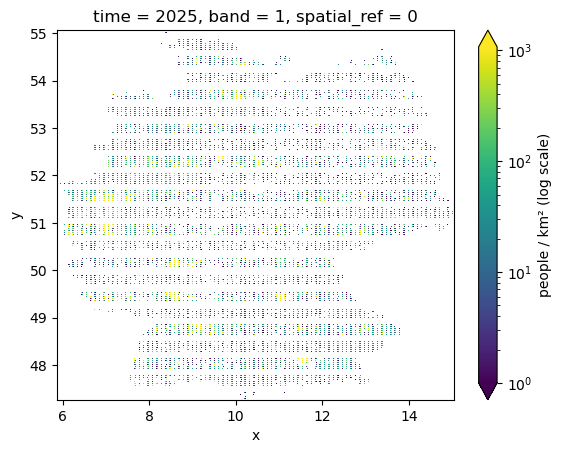

In [45]:
pop2025 = ds.population.sel(time=2025)

vmax = pop2025.quantile(0.98).item()      # DataArray → float
pop2025.plot.imshow(
    cmap="viridis",
    norm=LogNorm(vmin=1, vmax=vmax),      # real LogNorm object
    cbar_kwargs={"label": "people / km² (log scale)"},
)
plt.show()


Finally, let's see how we can access the value of a single spatial unit, in this case, a pixel, throughout time.

As a benchmark, first we determine the location of the most populated pixel in 2025:

In [51]:
# open cube
ds  = xr.open_dataset("GHSL_Germany_2000-2025.nc", decode_coords="all")
pop = ds.population

# pixel with the largest 2025 value
iy, ix = np.unravel_index(np.nanargmax(pop.sel(time=2025)), pop.isel(time=0).shape)
ts     = pop.isel(y=iy, x=ix)                 # (time,) DataArray

Then query the pixel values and visualize them as a time series:

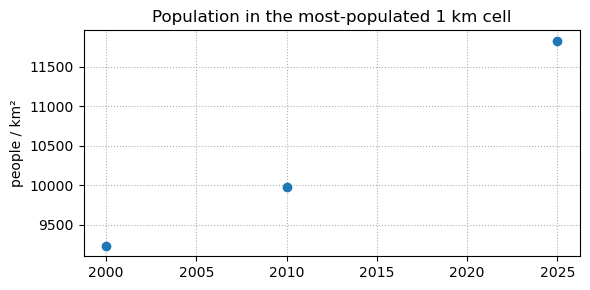

In [52]:
# plot, forcing every epoch label to appear
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(ts.time, ts, marker="o")
ax.set_ylabel("people / km²")
ax.set_title("Population in the most-populated 1 km cell")

# ── show every year stamp ───────────────────────────
ax.set_xticks(ts.time.values)                 # all 6 ticks
ax.set_xticklabels(ts.time.values.astype(str))
ax.grid(ls=":")

plt.tight_layout(); plt.show()


Here we see a surprising result - while we have 6 temporal snapshots, we only got 3 data points. This means that the exact selected pixel is not present with the same indicies in all snapshots. 

There are a couple likely reasons for this. First, the data sets were prepered slightly differently. Second might be that cropping the pixels around the boundary lines of Germany resulted some pixels to be on one line or the other of the mask, resulting a random +/-1 pixel shift in the indicies.

In the future, to overcome such complications, I recommend to combine this section and the previous one and create your own grid, for instance, using uber H3. 



In this section, we learned how we can read, analyze, process, and combine spatiotemporal raster data. We quickly also learned about change detection and the advanced data format called NetCDF.


I also encourage you to map this raster into hexagon grids and explore the changes on the level of hexagons as well.